# Part 1: Setup Project

## Objective

General setup:

- Install dependencies, import TensorFlow Layers
- Config GPU


## 1.1 Install and import dependencies

First create a virtual environment for the project

**Uncommet some code lines if you run this notebook for the first time**


In [1]:
# Run these comments in the same project directory to create a virtual environment
#%python3 -m venv venv

# Activate the virtual environment
#%source venv/bin/activate

Then install the dependencies

In [2]:
#%pip install tensorflow 

In [3]:
#%pip install opencv-python

In [4]:
#%pip install matplotlib

In [5]:
#%pip install scikit-learn

In [6]:
# %pip install seaborn

Now import some necessary dependencies

In [6]:
import cv2 # OpenCV
import os  # For file operations
import random
import numpy as np
from matplotlib import pyplot as plt # For plotting graphs
from mtcnn.mtcnn import MTCNN
from numpy import savez_compressed
from PIL import Image

In [2]:
# Import TensorFlow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D,  Dense, MaxPool2D, Flatten, Input
import tensorflow as tf


2024-10-30 13:03:49.710408: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 13:03:49.872119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 13:03:49.959409: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 13:03:49.984908: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 13:03:50.120170: I tensorflow/core/platform/cpu_feature_guar

- Conv2D for Convolutional Neural Networks
- Dense for Fully Connected Neural Networks
- MaxPooling2D to pull our layers together and effectively reduce the number of parameters and computations in the network
- Flatten take output from previous layer and flatten it to a vector to be fed into the next layer

## 1.2 Setup GPU Limit for TensorFlow

In [9]:
# Avoid Memory Error when TensorFlow use two much VRAM
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
gpus # Show all GPUs available in machine

[]

# Part 2: Load and Preprocess Data

## Objective

## 2.1 Create Data Folder, create positive and negative pairs, label them

The Siamese network is integrated with preprocessing steps already, witohut sharing with the `DataPreprocessing.ipynb` notebook due to the approach of the model.

The process will be quite similar to the `DataPreprocessing.ipynb` notebook, but there will be some differences after the face detection step. 

In the `DataPreprocessing.ipynb` notebook, we used a pre train model to extract the the face embeddings. Just calling and it will do the job (aka, use model to give the prediction without training since it already pretrain model). However, in this Siamase Network, we even try to train the model how to extract these features.




Data organized into pairs:

     - Positive pairs: Two images of the same person
     - Negative pairs: Two images of different people
     
   - Training Process:
     - Network learns feature extraction from scratch
     - Pairs are fed through identical twin networks
     - Distance between feature vectors is computed
     - Loss function:
       * Minimizes distance for positive pairs
       * Maximizes distance for negative pairs
     - **Network iteratively improves feature extraction based on distance metrics**



In [4]:
# Create preprocessed_data(for Siamese) folder
os.makedirs('preprocessed_data(for_Siamese)', exist_ok=True)

# Inside that folder, create face_detect folder and face_embeddings folder
os.makedirs(os.path.join('preprocessed_data(for_Siamese)', 'face_detect'), exist_ok=True)

# since Siamese network base on feedback distance to update the extract features phase, we 
# can not have 'face_embeddings' folder at scratch

In [9]:
### Now, from the `data` folder, extract end align the faces (crop image to keep only face) 
# and save them in the `face_detect` folder ###


# Detect and extract faces from an image using MTCNN
# Parameters:
# - image_path: path to the image file
# - detector: MTCNN detector object
# - required_size: the size of the extracted face images (default is (160, 160))
def detect_and_extract_faces(image_path, detector, required_size=(160, 160)):
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    detections = detector.detect_faces(image_np)
    faces = []
    for detection in detections:
        x, y, width, height = detection['box']
        face = image_np[y:y+height, x:x+width]
        face_image = Image.fromarray(face).resize(required_size)
        faces.append(np.array(face_image))
    return faces

# Process a single subfolder (since the data folder contains subfolders for each person, use this function to process each subfolder)
# Parameters:
# - subfolder: the subfolder name in data folder we want to process
# - face_only_dataset_dir: the directory to save the extracted faces. This is the subfolder with person's name inside the face_detect folder

# - detector: MTCNN detector object
def process_subfolder(subfolder, face_only_dataset_dir, detector):
    subfolder_path = os.path.join('./data', subfolder) #Acessing the subfolder
    new_faces_folder = os.path.join(face_only_dataset_dir, os.path.basename(subfolder))
    
    # Create the new_faces_folder if it does not exist
    os.makedirs(new_faces_folder, exist_ok=True)
    
    image_files = [f for f in os.listdir(subfolder_path) if f.endswith('.jpg')] # For all images inside a person folder in the subfolder 
    faces = []
    
    for image_file in image_files:
        image_path = os.path.join(subfolder_path, image_file)
        extracted_faces = detect_and_extract_faces(image_path, detector)
        
        for i, face in enumerate(extracted_faces):
            face_image = Image.fromarray(face)
            face_image_path = os.path.join(new_faces_folder, f'{os.path.splitext(image_file)[0]}_face_{i+1}.jpg')
            face_image.save(face_image_path)
        
        faces.extend(extracted_faces)
    
    # Ensure all faces have the same shape before saving to .npz
    if faces:
        face_shape = faces[0].shape
        faces = [face for face in faces if face.shape == face_shape]
        faces = np.array(faces)
        savez_compressed(os.path.join(new_faces_folder, 'faces.npz'), faces)



`faces.npz` is just simply a compressed file that contains all list of numpy arrays, where each numpy array is a face image. 

In [10]:

# Main function to process all subfolders

detector = MTCNN()

# Except the README file, process all subfolders

for subfolder in os.listdir('./data'):
    if subfolder == 'README.md':
        continue
    print("Processing face detection for:", subfolder)
    process_subfolder(subfolder, './preprocessed_data(for_Siamese)/face_detect', detector)

Processing face detection for: Steve_Avery
Processing face detection for: Nigel_Redden
Processing face detection for: Chang_Saio-yue
Processing face detection for: Hussein_Malik
Processing face detection for: Ali_Adbul_Karim_Madani
Processing face detection for: Sebastien_Grosjean
Processing face detection for: Lionel_Chalmers
Processing face detection for: Roger_Machado
Processing face detection for: Sonja_Kesselschlager
Processing face detection for: Zhang_Yimou
Processing face detection for: Claudia_Schiffer
Processing face detection for: Tzipora_Obziler
Processing face detection for: Miguel_Cotto
Processing face detection for: Scott_Hoch
Processing face detection for: Thomas_Malchow
Processing face detection for: Joel_Gallen
Processing face detection for: Corey_Maggette
Processing face detection for: Anne_ONeil
Processing face detection for: Kim_Jin-sun
Processing face detection for: Nora_Ephron


First subfolder: Steve_Avery
Keys in the .npz file: ['arr_0']
Shape of faces array: (1, 160, 160, 3)
Shape of the first face: (160, 160, 3)


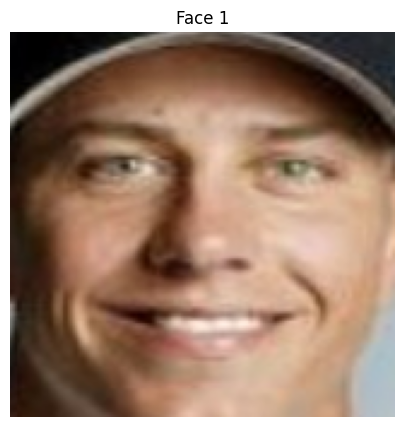

In [11]:
# Testing: load a faces.npz file in the first subfolder and display the faces

# Get the path to the first subfolder
first_subfolder = os.listdir('./preprocessed_data/face_detect')[0]
print("First subfolder:", first_subfolder)

# Load the .npz file
npz_file_path = os.path.join('./preprocessed_data/face_detect', first_subfolder, 'faces.npz')
test = np.load(npz_file_path)

# Print the keys in the .npz file
print("Keys in the .npz file:", test.files)

# Extract the faces array
faces = test['arr_0']

# Print the shape of the faces array
print("Shape of faces array:", faces.shape)

# Print the shape of the first face
face_shape = faces[0].shape
print("Shape of the first face:", face_shape)

# Plot the faces
plt.figure(figsize=(20, 5))
for i, face in enumerate(faces):
    plt.subplot(1, len(faces), i+1)
    plt.axis('off')
    plt.title(f"Face {i+1}")
    plt.imshow(face)
plt.show()

In [13]:
# Now we create positive and negative pairs for the Siamese network


# Load face images from the .npz files
# Parameters:
# face_dir: directory containing the face images
def load_faces(face_dir):
    faces_dict = {}
    for subfolder in os.listdir(face_dir):  # Process each subfolder/person
        subfolder_path = os.path.join(face_dir, subfolder)
        if os.path.isdir(subfolder_path):
            data = np.load(os.path.join(subfolder_path, 'faces.npz'))
            faces = data['arr_0']
            faces_dict[subfolder] = faces
    return faces_dict  # Dictionary with key: person name, value: face images

# Create pairs of face images and corresponding labels
# Parameters: 
# faces_dict: dictionary containing face images of each person
# num_negative_samples: number of negative samples to create for each positive pair
# num_subfolders_to_sample: number of subfolders to sample for negative pairs
def create_pairs(faces_dict, num_negative_samples=5, num_subfolders_to_sample=3):
    pairs = []
    labels = []
    persons = list(faces_dict.keys())
    
    # Create positive pairs
    for person in persons:
        faces = faces_dict[person]
        for i in range(len(faces)):
            for j in range(i + 1, len(faces)):
                pairs.append([faces[i], faces[j]])
                labels.append(1)
    
    # Create negative pairs with random sampling
    for person in persons:
        faces = faces_dict[person]
        other_persons = [p for p in persons if p != person]
        sampled_persons = random.sample(other_persons, min(num_subfolders_to_sample, len(other_persons)))
        
        for face in faces:
            for sampled_person in sampled_persons:
                sampled_faces = faces_dict[sampled_person]
                sampled_negative_faces = random.sample(list(sampled_faces), min(num_negative_samples, len(sampled_faces)))
                
                for neg_face in sampled_negative_faces:
                    pairs.append([face, neg_face])
                    labels.append(0)
    
    return np.array(pairs), np.array(labels)

# Load face images
face_dir = './preprocessed_data(for_Siamese)/face_detect'
faces_dict = load_faces(face_dir)

# Create pairs and labels with random sampling for negative pairs
pairs, labels = create_pairs(faces_dict, num_negative_samples=1, num_subfolders_to_sample=1)
print("Number of pairs:", len(pairs))
print("Number of positive pairs:", sum(labels))  # since positive pairs are labeled as 1, negative are 0, 0 + 1 = 1
print("Number of negative pairs:", len(labels) - sum(labels))

# Prepare data
X = np.array([np.concatenate(pair) for pair in pairs])
y = labels

print("Shape of training data:", X.shape)
print("Shape of labels:", y.shape)

Number of pairs: 46
Number of positive pairs: 16
Number of negative pairs: 30
Shape of training data: (46, 320, 160, 3)
Shape of labels: (46,)


BEING FIX ..................................

In [15]:
# Defined the Camera ID to use
CAM_ID = 3 # Establishing the connection with the IR camera


- CAM_ID = 0 for laptop normal webcam
- CAM_ID = 2 for laptop IR webcam
- CAM_ID = 4 for external webcam


***Depend on each devices, these number can be different. Try out all number start from 0 and see which one is the correct one on your device.***


Set up camera:

**IR webcam:**

What is IR webcam? https://fptshop.com.vn/tin-tuc/danh-gia/ir-camera-la-gi-153147


**External webcam**

Since the resolution of the laptop webcam is not good, we will use an external webcam like from a mobile phone. To connect the webcam to the laptop:

1. Download the DroidCam app on your phone, also the DroidCam client on your laptop: https://www.dev47apps.com/
2. Set up as the instruction on the website. With Linux:

```bash
wget -O droidcam_latest.zip https://files.dev47apps.net/linux/droidcam_2.1.3.zip
unzip droidcam_latest.zip -d droidcam
cd droidcam && sudo ./install-client
sudo apt install libappindicator3-1

# Fix missing video device
sudo apt install linux-headers-`uname -r` gcc make
sudo ./install-video
```
3. Open both DroidCam on phone and DroidCam client on laptop, connect the phone to the laptop via USB or Wifi.


Now try to use OpenCV to capture the image from the webcam:


In [16]:
# cap = cv2.VideoCapture(CAM_ID)  # Connect to the camera
# while cap.isOpened():  # Loop through every single frame
#     ret, frame = cap.read()  # Read the frame
#     if not ret:
#         break

#     cv2.imshow('Testing Webcam with OpenCV, press q to quit', frame)  # Display the frame to screen

#     if cv2.waitKey(1) & 0xFF == ord('q'):  # Wait for 1ms and check if 'q' is pressed
#         break

# cap.release() 
# cv2.destroyAllWindows()  # Close the window

**Press `q` to exit**


After that, we show to last frame/image captured when press `q`:

In [17]:
#plt.imshow(frame) # Display the image

Note that by default, OpenCV reads images in **BGR** (Blue, Green, Red) format so the image will look a bit weird.

In [18]:
#frame.shape # Check the shape of the image

In [19]:
#frame

When using normal webcam, the result look something like this:

```plaintext
array([[[181, 163, 164],
        [186, 168, 168],
        [186, 164, 168],
        ...,
        [104, 107, 104],
        [104, 106, 106],
        [105, 107, 107]],

       [[183, 167, 167],
        [183, 167, 167],
        [180, 162, 163],
```
Each [181, 163, 164] is a pixel value of the image. The first value is the Blue channel, the second is the Green channel, and the third is the Red channel. The value of each channel is from 0 to 255.

Whereas when using IR webcam, the result look something like this:

```plaintext
array([[[16, 16, 16],
        [15, 15, 15],
        [23, 23, 23],
        ...,
        [ 6,  6,  6],
        [ 7,  7,  7],
        [ 6,  6,  6]],
```

Each picxel is just a single value, which is the gray intensity of the pixel. The value is from 0 to 255. However they are write duplicated 3 times to match the RGB format, so when use frame.shape, it will return (480, 640, 3) instead of (480, 640, 1).

However, this is not 250x250 yet, we will resize the image to 250x250.




In [20]:
#Resize the image to 250x250
#resized_frame = cv2.resize(frame, (250, 250))
#plt.imshow(resized_frame)

### Face Detection

Just resize the image to 250x250 will make the image look weird, so instead, we should crop the image to 250x250, by not by arbitrary, but by the face of the person in the image. We will use the Haar Cascade Classifier to detect the face in the image and crop the image to the face. First we test the Haar Cascade Classifier to see if it can detect the face in the image.

In [21]:
# # Load the Haar Cascade Classifier for face detection
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# # Convert the frame to grayscale as the face detector expects gray images
# gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# # Detect faces in the image
# faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

# # If faces are detected, crop the first face found
# if len(faces) > 0:
#     (x, y, w, h) = faces[0]  # Get the coordinates of the first face
#     cropped_face = frame[y:y+h, x:x+w]  # Crop the face from the frame

#     # Resize the cropped face to 250x250
#     resized_face = cv2.resize(cropped_face, (250, 250))

#     # Display the resized face
#     plt.imshow(cv2.cvtColor(resized_face, cv2.COLOR_BGR2RGB))
#     plt.show()
# else:
#     print("No faces detected")

Tim hieu them ve tuat toanFace Detection nay ????

### Collect images to anchor and positive folders

Now we will collect the images to the anchor and positive folders. 

First, we specify the name of the person we want to collect the training images for. Then we will create a subfolder with that name inside the `data/anchor` and `data/positive` folder respectively. Then capture images of that person and save to the corresponding subfolder. 


Create a capture frame, then:

- press `a`: detect the face in current frame then crop that face to 250x250 image then save to the `anchor/input_name` folder
- press `p`: detect the face in current frame then crop that face to 250x250 image then save to the `positive/input_name` folder
 
Notify to the user when the image is saved successfully or not

In [22]:
import uuid # For generating unique image file names

# Function to save the captured image to the specified folder
def save_image(image, folder_path, img_name):
    img_path = os.path.join(folder_path, img_name)
    cv2.imwrite(img_path, image)

# Initialize the webcam
cap = cv2.VideoCapture(CAM_ID)
# Load the Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


# We now capture the images and save them to the 'data/anchor' and 'data/positive' folders with corresponding subfolders name
name = input("Name of the person to store in training data: ")

# Loop through every frame in the webcam feed
while cap.isOpened():
    
    ret, frame = cap.read()
    if not ret:
        break



    # Display the frame
    cv2.imshow('Face collect to anchor, positive folder to train model, option: a, p, q', frame)
    # Check for key presses
    key = cv2.waitKey(1) & 0xFF
    if key == ord('a'):
        # Detect face in the frame then crop to 250x250 around the face and save to 'data/anchor'
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            cropped_face = frame[y:y+h, x:x+w]
            resized_face = cv2.resize(cropped_face, (250, 250))
            save_path = os.path.join(ANC_PATH, name)
            os.makedirs(save_path, exist_ok=True)
            save_image(resized_face, save_path, str(uuid.uuid1())+ ".jpg")
            print("Image saved as anchor")
        else:
            # Show a dialog if no faces are detected
            print("No faces detected")


    elif key == ord('p'):
        # Detect face in the frame then crop to 250x250 around the face and save to 'data/positive'
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            cropped_face = frame[y:y+h, x:x+w]
            resized_face = cv2.resize(cropped_face, (250, 250))
            save_path = os.path.join(POS_PATH, name)
            os.makedirs(save_path, exist_ok=True)
            save_image(resized_face, save_path, str(uuid.uuid1())+ ".jpg")
            print("Image saved as positive")
        else:
            # Show a dialog if no faces are detectedq
            print("No faces detected")

    elif key == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()

The final struccture of the `data` folder should look like this:

```plaintext
data/
├── anchor/
│   ├── chutrunganh/.... (Some images inside)
│   ├── buiduyanh/...
│   └── phammanhtien/...
│ 
├── positive/
│   ├── chutrunganh/...
│   ├── buiduyanh/...
│   └── phammanhtien/...
│ 
└── negative/...
```

Note that the `data` folder is not included when you clone the project, due to:

- negative folder: is too large to upload, just download from the LFW dataset and extract by yourself
- anchor and positive folder: is our personal images taken directly from Webcam, so we dont want to public that

So you may need to create the above structure by yourself using the  collection images code above.

# Part 3: Prepare the Dataset

## Objective

- Preprocess the images
- Create dataset
- Suffule and split the dataset

## 3.1 Preprocess the images

We define a function to preprocess the images. The function accepts the inpput as the image path (string format) or the frame (numpy array format). 

Why we need two of these:

- When we want to process the images to create the dataset, provide image path to load images from the disk

- When we want to verify the image directly from the camera, provide the frame object by OpenCV to the function. (we do this in Part 7)

Ham nay can them phan xu ly image. Truoc mat da xu ly crop. Can xu ly enhance contrast, brightness, sharpen, noise reduction, etc. ????

In [70]:
import tensorflow as tf

def preprocess(input_data):
    """
    Preprocess image data from various input formats into a standardized tensor.
    
    Args:
        input_data: Can be a file path (str), bytes tensor, or numpy array
    
    Returns:
        A preprocessed tensor of shape (100, 100, 3) with values in [0,1]
    """
    try:
        if isinstance(input_data, (str, bytes)) or (isinstance(input_data, tf.Tensor) and input_data.dtype == tf.string):
            # Convert tensor to string if needed
            if isinstance(input_data, tf.Tensor):
                input_data = input_data.numpy()
            if isinstance(input_data, bytes):
                input_data = input_data.decode('utf-8')
                
            # Read and decode the image
            byte_image = tf.io.read_file(input_data)
            image = tf.image.decode_jpeg(byte_image, channels=3)
            
            # Convert to float32 after decoding
            image = tf.cast(image, tf.float32)
        else:
            # Handle numpy array input
            image = tf.convert_to_tensor(input_data)
            if image.dtype != tf.float32:
                image = tf.cast(image, tf.float32)
    
        # Ensure shape is correct
        if len(image.shape) != 3:
            raise ValueError(f"Expected image with 3 dimensions, got shape {image.shape}")
            
        # Preprocess the image
        image = tf.image.resize(image, (100, 100))

        image = image / 255.0  # Normalize to [0,1]

        # Apply gamma correction based on the mean brightness of the image
        mean_brightness = tf.reduce_mean(image)
        image = tf.image.adjust_gamma(image, tf.clip_by_value(tf.math.log(0.5) / tf.math.log(mean_brightness + 1e-10), 0.5, 2.0))
        
        # Enhace image contract automatically
        
        # lam phan nay di DUY ANH :))

        

        return image
    
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        print(f"Input type: {type(input_data)}")
        if isinstance(input_data, (str, bytes)):
            print(f"Input path: {input_data}")
        raise

# Note that our preprocess function return a Tensorflow tensor, not a numpy array, so when need  to  perform image 
# with OpenCV, we need to convert it to numpy array

# Wrap the preprocess function in a tf.py_function to deal with Frame objects in Opencv
def preprocess_wrapper(input_data):
    return tf.py_function(preprocess, [input_data], tf.float32)

The correct dimension to resize will base on the model we use. For example:

- VGGFace: 224x224
- Facenet: 160x160
- ....

In this case, we use the Siamese model, the input size is 105x105, but we resize the image to 100x100, still work well.

**Thu tim them cac model khac va kich thuoc anh phu hop????**


Test the `prepreprocess` function with an example image:

Value range before preprocessing: 6 - 255


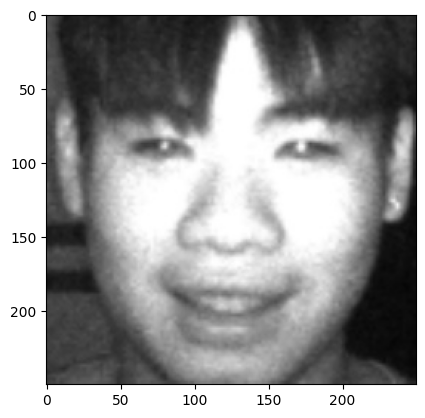

Value range after preprocessing: 0.021119066 - 1.0


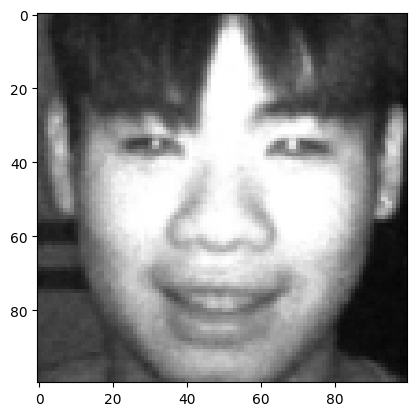

In [71]:
# Take an example image to test the preprocess function
#first, take the first folder in the anchor folder for example
example_anchor_folder_path = os.path.join(ANC_PATH, os.listdir(ANC_PATH)[0]) # Access the first folder in the anchor folder (name of some person)
example_image_path = os.path.join(example_anchor_folder_path, os.listdir(example_anchor_folder_path)[0]) # Access the first image in the folder


# Images before preprocessing
original_image_test = cv2.imread(example_image_path)
plt.imshow(cv2.cvtColor(original_image_test, cv2.COLOR_BGR2RGB))
print("Value range before preprocessing:", original_image_test.min(), "-", original_image_test.max()) # Value range
plt.show()



# Images after preprocessing
preprocessed_image_test = preprocess(example_image_path)
plt.imshow(cv2.cvtColor(preprocessed_image_test.numpy(), cv2.COLOR_BGR2RGB))
print("Value range after preprocessing:", preprocessed_image_test.numpy().min(), "-", preprocessed_image_test.numpy().max()) # Value range
plt.show()


## 3.2 Create labled Dataset

We want to create a dataset that labels as follow:

- Given two input: Anchor + Positive => Then assign the label as 1
- Given two input: Anchor + Negative => Then assign the label as 0

Loop through the same name subfolder in the `anchor` and `positive` folder, with each subfolder, store images simultaneously to the `anchor_images_general` and `positive_images_general` list. This will ensure that images are aligned, meaning the images in the same index of the two lists are the images of the same person. Then create the positive samples by combining the anchor and positive images together with the label 1.

For the negative class, just simply loop through the `negative` folder and store the images to the `negative_images_general` list. Then combine with images in the `anchor_images_general` list to create the negative samples with the label 0. Those are just strangers, so we don't need to care about the alignment of the images.

![CreateDataset](resources/images/CreateDataset.drawio.png)



Notetice that the `negative` folder come from LWF dataset, meanings it contains about  13,000 images of different persons. We will not need to use that much since our we only need a limit number same size as the number of anchor images to map. So we will pass a parameter to the function, which limit the number of negative images we want to take. This will significantly reduce the create time of the dataset.

Note that, we apply `preprocess` function to the images before store to the dataset.

In [72]:
# First, we align the images in the anchor and positive folders by read and store them in corresponding lists
def combine_images(limit_sample_to_take):
    anchor_images_general = []
    positive_images_general = []
    negative_images_general = []

    # Iterate through each person's folder in the anchor and positive directories
    for person_name in os.listdir(ANC_PATH):
        print("Start processing personal data of: ", person_name)
        person_anchor_dir = os.path.join(ANC_PATH, person_name)
        person_positive_dir = os.path.join(POS_PATH, person_name)

        if os.path.isdir(person_anchor_dir) and os.path.isdir(person_positive_dir): # Check if the path is a valid directory
            for anchor_img in os.listdir(person_anchor_dir): # Loop through all images inside a person's anchor folder
                anchor_img_path = os.path.join(person_anchor_dir, anchor_img)
                # Convert image to tensor`
                anchor_images_general.append(preprocess(anchor_img_path))
                
            for positive_img in os.listdir(person_positive_dir): # Loop through all images inside a person's positive folder
                positive_img_path = os.path.join(person_positive_dir, positive_img)
                positive_images_general.append(preprocess(positive_img_path))

        print("Complete processing personal data of: ", person_name)


    # Iterate through the negative directory
    # Loop through images in the negative folder. However, we will limit the number of negative images, since there are 
    # too many images inside this folder
    for negative_img in os.listdir(NEG_PATH)[:limit_sample_to_take]:
        negative_img_path = os.path.join(NEG_PATH, negative_img)
        negative_images_general.append(preprocess(negative_img_path))

    return anchor_images_general, positive_images_general, negative_images_general


# Specify the number of samples to take from each list
NUMBER_OF_SAMPLES_TO_TAKE = 30


anchor_images_general, positive_images_general, negative_images_general = combine_images(NUMBER_OF_SAMPLES_TO_TAKE)

# Convert lists to TensorFlow datasets
anchor_ds = tf.data.Dataset.from_tensor_slices(anchor_images_general).take(NUMBER_OF_SAMPLES_TO_TAKE)
positive_ds = tf.data.Dataset.from_tensor_slices(positive_images_general).take(NUMBER_OF_SAMPLES_TO_TAKE)
negative_ds = tf.data.Dataset.from_tensor_slices(negative_images_general).take(NUMBER_OF_SAMPLES_TO_TAKE)






Start processing personal data of:  tangbalam
Complete processing personal data of:  tangbalam
Start processing personal data of:  chutrunganh
Complete processing personal data of:  chutrunganh


After combine imges from corresponding folders, visualize images in each list to see if images are aligned correctly.

2024-10-24 14:07:49.891142: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


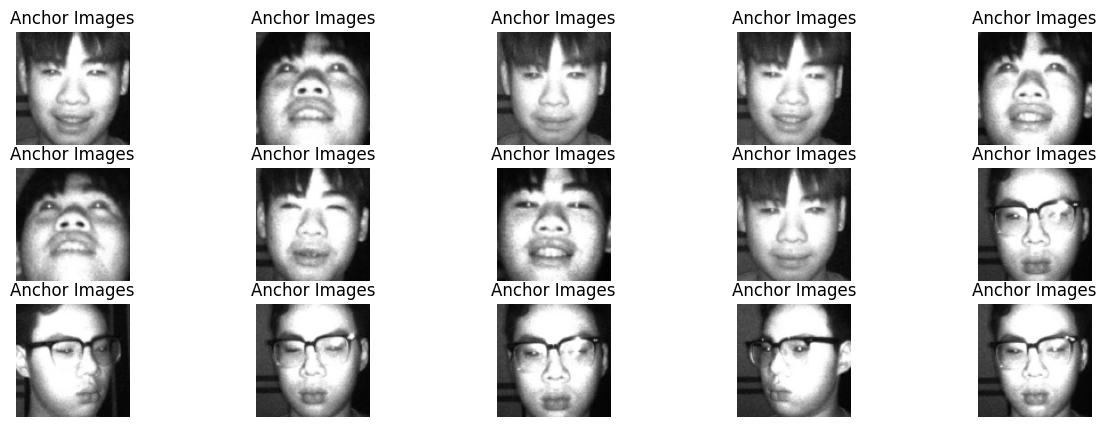

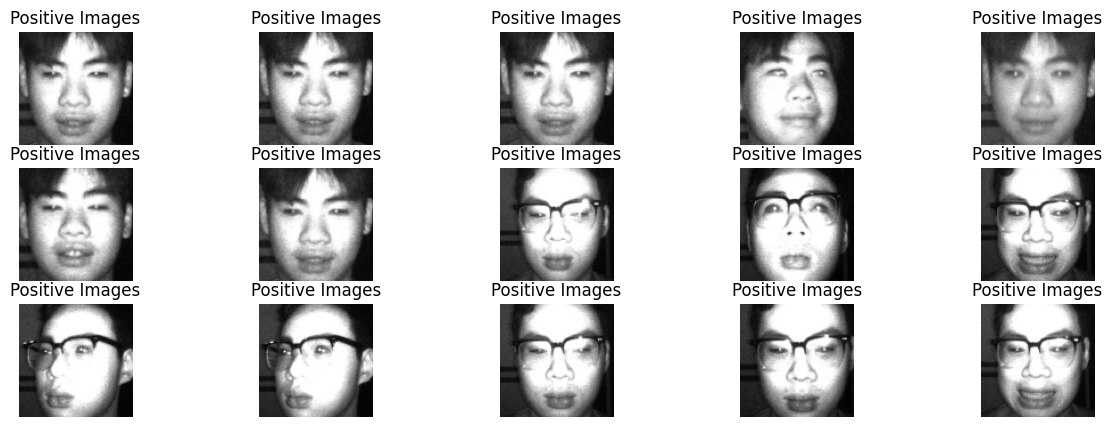

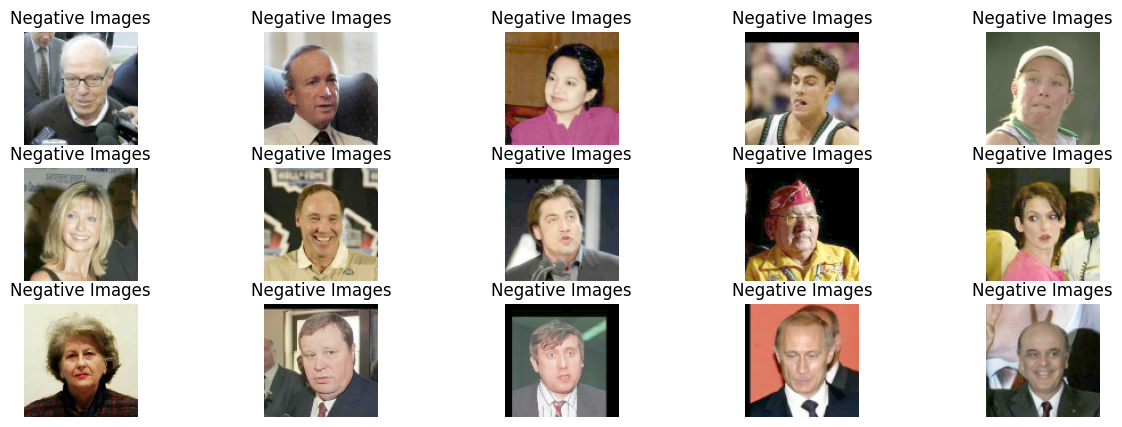

In [73]:
# Visualize three lists of images, each list takes 5 images from the start, middle, and end of the dataset
def display_sample(dataset, title, num_images=5):
    """
    Display a sample of images from the dataset.
    
    Args:
        dataset: A TensorFlow dataset containing images.
        title: Title for the displayed images.
        num_images: Number of images to display from the start, middle, and end of the dataset.
    """
    # Convert dataset to a list for easier slicing
    dataset_list = list(dataset.as_numpy_iterator())
    
    # Get the first `num_images`, middle `num_images`, and the last `num_images` images
    middle_start = len(dataset_list) // 2 - num_images // 2
    sample_images = dataset_list[:num_images] + dataset_list[middle_start:middle_start + num_images] + dataset_list[-num_images:]
    
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(sample_images):
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(image)
        plt.title(title)
        plt.axis("off")
    plt.show()

# Display samples from each dataset

display_sample(anchor_ds, "Anchor Images")
display_sample(positive_ds, "Positive Images")
display_sample(negative_ds, "Negative Images")

Now we create the Label for each of our combine images to create the dataset. The label is 1 for positive samples and 0 for negative samples.


In [74]:
# Now each image in anchor zip with a positive image and label 1, and with a negative image and label 0
# Create labels
positive_labels = tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor_ds))) #each label has the same size as the anchor
negative_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor_ds)))

# Zip the datasets with their labels
positives = tf.data.Dataset.zip((anchor_ds, positive_ds, positive_labels))
negatives = tf.data.Dataset.zip((anchor_ds, negative_ds, negative_labels))

# Concatenate the datasets
data = positives.concatenate(negatives)
data = data.cache() # Cache the data for faster training

In [75]:
# Example of a sample from the dataset
samples = data.as_numpy_iterator()
sample = samples.next()

sample

(array([[[0.308267  , 0.308267  , 0.308267  ],
         [0.3109662 , 0.3109662 , 0.3109662 ],
         [0.27046105, 0.27046105, 0.27046105],
         ...,
         [0.16863595, 0.16863595, 0.16863595],
         [0.17036046, 0.17036046, 0.17036046],
         [0.15089105, 0.15089105, 0.15089105]],
 
        [[0.32028955, 0.32028955, 0.32028955],
         [0.29845038, 0.29845038, 0.29845038],
         [0.26088145, 0.26088145, 0.26088145],
         ...,
         [0.1723312 , 0.1723312 , 0.1723312 ],
         [0.15656097, 0.15656097, 0.15656097],
         [0.14275345, 0.14275345, 0.14275345]],
 
        [[0.31808156, 0.31808156, 0.31808156],
         [0.28396693, 0.28396693, 0.28396693],
         [0.24122366, 0.24122366, 0.24122366],
         ...,
         [0.17651853, 0.17651853, 0.17651853],
         [0.16099738, 0.16099738, 0.16099738],
         [0.14891857, 0.14891857, 0.14891857]],
 
        ...,
 
        [[0.21786618, 0.21786618, 0.21786618],
         [0.2540024 , 0.2540024 , 0.25400

Label: 1.0


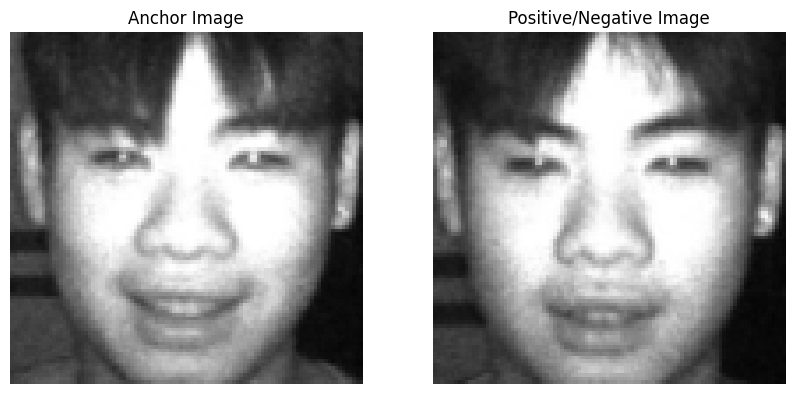

In [76]:
## Visualize a sample from the dataset ##

def display_sample_with_label(sample):
    """
    Display a sample of images with labels.
    
    Args:
        sample: A tuple containing an anchor image, a positive/negative image, a label, and possibly additional data.
    """
    # Adjust the unpacking based on the actual structure of the sample
    anchor_img, pos_neg_img, label, *additional_data = sample
    
    plt.figure(figsize=(10, 5))
    
    # Display anchor image
    ax = plt.subplot(1, 2, 1)
    plt.imshow(anchor_img)
    plt.title("Anchor Image")
    plt.axis("off")
    
    # Display positive/negative image
    ax = plt.subplot(1, 2, 2)
    plt.imshow(pos_neg_img)
    plt.title("Positive/Negative Image")
    plt.axis("off")
    
    # Print the label
    print("Label:", label)
    
    plt.show()



# Display the sample with label
display_sample_with_label(sample)

Last sample: (array([[[0.29172176, 0.29172176, 0.29172176],
        [0.27670053, 0.27670053, 0.27670053],
        [0.26747033, 0.26747033, 0.26747033],
        ...,
        [0.04792467, 0.04792467, 0.04792467],
        [0.05505389, 0.05505389, 0.05505389],
        [0.06753635, 0.06753635, 0.06753635]],

       [[0.295318  , 0.295318  , 0.295318  ],
        [0.28383663, 0.28383663, 0.28383663],
        [0.24614511, 0.24614511, 0.24614511],
        ...,
        [0.04916001, 0.04916001, 0.04916001],
        [0.05343526, 0.05343526, 0.05343526],
        [0.07507244, 0.07507244, 0.07507244]],

       [[0.27243385, 0.27243385, 0.27243385],
        [0.28050262, 0.28050262, 0.28050262],
        [0.27148724, 0.27148724, 0.27148724],
        ...,
        [0.05795144, 0.05795144, 0.05795144],
        [0.05904449, 0.05904449, 0.05904449],
        [0.06679031, 0.06679031, 0.06679031]],

       ...,

       [[0.14949857, 0.14949857, 0.14949857],
        [0.16458458, 0.16458458, 0.16458458],
        

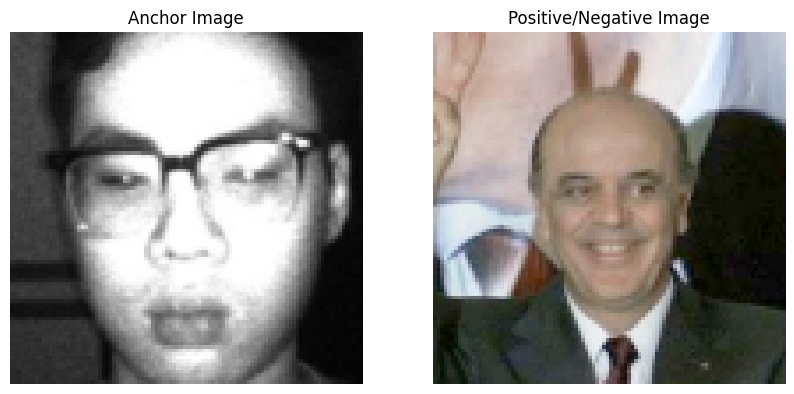

In [77]:
## Visualize the last sample from the dataset ##

# Convert the dataset to a list
dataset_list = list(data.as_numpy_iterator())

# Access the last element
last_sample = dataset_list[-1]

# Display the last sample
print("Last sample:", last_sample)


display_sample_with_label(last_sample)

## 3.3 Suffle, Build Train and Test Parition

Currently, the dataset contains **positive classes consecutively, then negative classes consecutively** after we concatenate them in previous step. We need to shuffle the dataset to make it more random.

In [78]:
# Before mix
for element in data.take(10):
    print(element[2].numpy())  # Print the label to see the mix of classes
# See if the appearance of 0 and 1 is random yet
# All 1.0 indicates that the fisrt half of the dataset is all positive class samples

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [79]:
# Shuffle the dataset so that we have a good mix of positive and negative examples
data = data.shuffle(buffer_size=1024) 

In [80]:
# Check the dataset again to see that the two classes are mixed well
for element in data.take(10):
    print(element[2].numpy())  # Print the label to see the mix of classes
# See if the appearance of 0 and 1 is random yet

1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0


Now we split the Dataset in to Training and Testing set. We will use **70% for training and 30% for testing**.

In [81]:
train_data = data.take(round(len(data)*0.7)) # 70% of the data for training
train_data = train_data.batch(16) # Batch size of 16; batch size" refers to the number of training examples utilized in one iteration of the training process.
train_data = train_data.prefetch(8) # start processing the next batch while the current batch is being processed

In [82]:
print("Size of original dataset:", len(data))
print("Size of training dataset:", len(list(train_data.as_numpy_iterator())))

Size of original dataset: 59
Size of training dataset: 3


In [83]:
# Note that now each sample in train_data is 16 images
for element in train_data.take(1):
    print(f"Size of each sample in train_data: {element[0].shape}, {element[1].shape}, {element[2].shape}")

Size of each sample in train_data: (16, 100, 100, 3), (16, 100, 100, 3), (16,)


(16, 100, 100, 3) represents the anchor images in one single sample:

- 16: meaning there are 16 images in this batch.
- 100, 100: the height and width of each image, indicating that each image is 100 pixels by 100 pixels.
- 3: the number of color channels in each image. We store the image as Gray scale, but the vluae is duplicated 3 times to match the RGB format.

Similiarly for the remaining two elements in the tuple.

Shape of element[0][0]: (100, 100, 3)
Values of element[0][0]:
[[[0.29172176 0.29172176 0.29172176]
  [0.27670053 0.27670053 0.27670053]
  [0.26747033 0.26747033 0.26747033]
  ...
  [0.04792467 0.04792467 0.04792467]
  [0.05505389 0.05505389 0.05505389]
  [0.06753635 0.06753635 0.06753635]]

 [[0.295318   0.295318   0.295318  ]
  [0.28383663 0.28383663 0.28383663]
  [0.24614511 0.24614511 0.24614511]
  ...
  [0.04916001 0.04916001 0.04916001]
  [0.05343526 0.05343526 0.05343526]
  [0.07507244 0.07507244 0.07507244]]

 [[0.27243385 0.27243385 0.27243385]
  [0.28050262 0.28050262 0.28050262]
  [0.27148724 0.27148724 0.27148724]
  ...
  [0.05795144 0.05795144 0.05795144]
  [0.05904449 0.05904449 0.05904449]
  [0.06679031 0.06679031 0.06679031]]

 ...

 [[0.14949857 0.14949857 0.14949857]
  [0.16458458 0.16458458 0.16458458]
  [0.15614901 0.15614901 0.15614901]
  ...
  [0.01956953 0.01956953 0.01956953]
  [0.01732469 0.01732469 0.01732469]
  [0.01717671 0.01717671 0.01717671]]

 [[0.165889

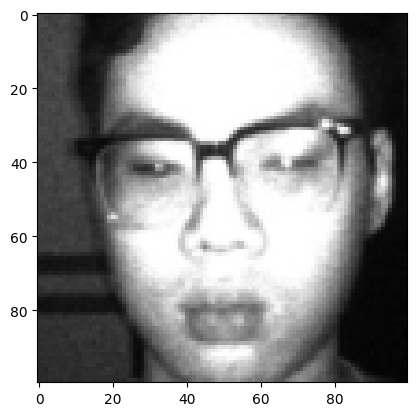

In [84]:
# Print the shape and values of element[0][0] (the first image in the first batch) to verify if it is stored as a grayscale image
print("Shape of element[0][0]:", element[0][0].shape)
print("Values of element[0][0]:")
print(element[0][0].numpy())

plt.imshow(element[0][0]) # Display the first image in the batch

In [85]:
# Do similar for the test data 30%
test_data = data.skip(round(len(data)*0.7)) # Skip the first 70% of the data which is used for training
test_data = test_data.take(round(len(data)*0.3)) 
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [86]:
print("Size of original dataset:", len(data))
print("Size of training dataset:", len(list(train_data.as_numpy_iterator())))
print("Size of test dataset:", len(list(test_data.as_numpy_iterator())))

Size of original dataset: 59
Size of training dataset: 3
Size of test dataset: 2


# Part 4: Build layers in model

## Objective

- Build an embedding layer / Encode Layer
- Create an L1 Distance layer
- Complie the Siamase Network

## 4.1 Build an Embedding Layer

Recall th idea, we have two stream of information (we  pass in two images: the anchor and the positive/negative image) -> Each stream will pass through an embedding layer to get the feature vector of the image -> Tow feature vectors will be used to calculate the distance between the two images at the Distance layer (here we use L1 distance).


Here is the Siamese Network architecture we are going to build:

![SiameseStructure](resources/images/SiameseStructure.png)

In the paper, it use input size of 105x105, but we will use 100x100 still okey. Therefore, **some numbers may not match exactly to the paper**

In [87]:
def make_embedding() :

    #Create the input layer
    inp = Input(shape=(100, 100, 3), name='input_image') # 100x100 image size, 3 channels color

   
    ### First Block ###
    # Next layer is a convolutional layer 64 filters, kernel size of 10x10, and ReLU activation
    c1= Conv2D(64, (10,10), activation='relu')(inp) # c1 stands for convolutional layer 1

    # Next layer is a max pooling layer with a pool size of 2x2
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1) 



    ### Second Block ###
    # Next layer is a convolutional layer 128 filters, kernel size of 7x7, and ReLU activation
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    # Next layer is a max pooling layer with a pool size of 2x2
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)



    ### Third Block ###
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    ### Fourth Block ###
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4) # Flatten the output of the convolutional layer to feed it to the dense layer
    d1 = Dense(4096, activation='sigmoid')(f1) # Dense layer with 4096 neurons and sigmoid activation

    
    return Model(inputs=[inp], outputs=[d1], name='Siamese__embedding_model')

As show in the above image, the output of the Embedding layer is a 4096-dimensional feature vector. Two streams of information will pass through this Embedding layer then we get two 4096-dimensional feature vectors for each image. **Basicaly, we are converting the face image to a 4096-dimensional feature vector.**

In [88]:
# Summary of the model
siamese_embedding_model = make_embedding()
siamese_embedding_model.summary()

Model: "Siamese__embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

How to read from the summary table:

This is a 4-dimensional tensor shape where each dimension represents, for example (None,100,100,3):

- None: This represents the batch size dimension. It's set to "None" because it's flexible - you can feed any number of images through the network at once.
- 100: The height of your input images (100 pixels)
- 100: The width of your input images (100 pixels)
- 3: The number of color channels

So in plain terms, your model is expecting input images that are:

- 100x100 pixels in size
- Color in 3 channels, can be RGB, BRG or even just grayscale but duplicated 3 times to match the format.
- Can be processed in batches of any size (that's what the None indicates)

## 4.2 Create an L1 Distance Layer

Compare two feature vectors to see how similiar our two images are uisng L1 distance. The L1 distance is the sum of the absolute differences between the two feature vectors.

Since there is no L1 distance layer in Keras, we will create a custom layer to calculate the L1 distance. The custom layer will take two feature vectors as input and output the L1 distance between them.

In [89]:

class L1Dist(Layer):
    def __init__(self, **kwargs):
         super(L1Dist, self).__init__(**kwargs)
    
    def call(self,input_embedding, validation_embedding):
        
        # Convert inputs to tensors otherwise will meet error: unsupported operand type(s) for -: 'List' and 'List'
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        input_embedding = tf.squeeze(input_embedding, axis=0)  # Remove potential first dimension
        validation_embedding = tf.squeeze(validation_embedding, axis=0)

        # Calculate and return the L1 distance
        return tf.math.abs(input_embedding - validation_embedding)
    

## 4.3 Create final Siamese Network

We combine two above steps to make a fully Siamese model

In [90]:
def make_siamese_model():

    embedding_model = make_embedding()

    # Handle input images
    input_image = Input(shape=(100, 100, 3), name='input_image') # Anchor image
    validation_image = Input(shape=(100, 100, 3), name='validation_image') # Positive or negative image


    # Generate embeddings for the input images
    
    input_embedding = embedding_model(input_image)
    validation_embdedding = embedding_model(validation_image)

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(input_embedding, validation_embdedding)
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Fully_Siamese_Network')


In [91]:
# Create the model
fully_siamese_model = make_siamese_model()
fully_siamese_model.summary()

Model: "Fully_Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Siamese__embedding… │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ Siamese__embeddi… │
│                     │                   │            │ Siamese__embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

Look at the summary table, we see that the input of the model is two images size 100,100,3. (How many images per batch is not specified, so it's flexible). The feature extraction vector (output of the Embedding layer) is **4096-dimensional**. 
The output is a **single value**, which is the distance between the two images.

# Part 5: Train the Siamese Network

## Objective

- Set up a loss function, set up an optimizer
- Establish checkpoints
- Build a Custom Training Step
- Create a Training Loop
- Train the model

## 5.1 Set up a loss function and an optimizer

In [92]:
#Define the loss function
binary_cross_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# from_logits=True is recommened when thr inputs to the loss function are not normalized 

In [93]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(1e-4)

There are tons of optimizer for Keras: SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam, Ftrl. We will use Adam optimizer.

## 5.2 Establish checkpoints

This checkpoint will save the model after each epoch. In case the training process is interrupted, we can resume the training from the last checkpoint.

In [94]:
# Create training_checkpoints directory in th machine
os.makedirs('./training_checkpoints', exist_ok=True)


checkpoint_dir = './training_checkpoints' # Directory to save the checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt") #Prefix for the checkpoint files with unique number
checkpoint = tf.train.Checkpoint(optimizer=optimizer, siamese_model=fully_siamese_model)

# To reload the model from the checkpoint, use model.load('path_to_checkpoint'). This will
# load pre trainweights and optimizer state into existing model

## 5.3 Build a Custom Training Step

In this step, we defined actual trainning steps. We train on one batch of data, one batch of data come through our training step, we go on makeing prediction -> calcualte our loss function -> calculate gradient then apply back popagation (calculate new weights and apply) through our neutral network to get the best possible model

In [95]:
@tf.function # Annotation to indicate that complies to TensorFlow graph execution 
def train_step(batch):

    with tf.GradientTape() as tape:  # Record operations for automatic differentiation
        
        # Get the input images, validation images and labels from a batch
        input_images, validation_images, labels = batch

        
        # Forward pass
        predictions = fully_siamese_model([input_images, validation_images], training=True)
        # Set training=True for is important since some layers will only activated when this is set to True
    
    
        # Calculate the loss
        loss = binary_cross_loss(labels, predictions) # Measure the difference between the predicted value and the actual value
        print("Loss Vaule: ", loss)
    
        # Calculate the gradients
        gradients = tape.gradient(loss, fully_siamese_model.trainable_variables)

        # Update the weights and apply to the Siamese model
        optimizer.apply_gradients(zip(gradients, fully_siamese_model.trainable_variables))
        # Adam is a variant of stochastic gradient descent, it applies te learning rate and gradient to slightly reduce the loss function, unitll
        # it realy near the minimum value.



Recall the batch we created before:


In [96]:
# take one testing batch from train_data
test_batch = train_data.as_numpy_iterator()
test_batch = test_batch.next()
print("The length of the batch is", len(test_batch))
print("The first element of the batch is 16 anchor images: ", test_batch[0].shape)
print("The second element of the batch is 16 validation images: ", test_batch[1].shape)
print("The third element of the batch is a single label 1 or 0 (but write duplicated 16 times): ", test_batch[2].shape)

The length of the batch is 3
The first element of the batch is 16 anchor images:  (16, 100, 100, 3)
The second element of the batch is 16 validation images:  (16, 100, 100, 3)
The third element of the batch is a single label 1 or 0 (but write duplicated 16 times):  (16,)


## 5.4 Build Training Loop

In [97]:
## Define how the training loop will work ##

def train(data, EPOCHS): # EPOCHS is the number of times the model will see the entire dataset

    # Loop through the epochs
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS)) # Print the current epoch to know the progress of runnig
        progressBar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run the training step here
            train_step(batch)
            progressBar.update(idx+1) # Update the progress bar

    # Save our checkpoint 
    if (epoch) % 10 == 0: # Save the model every 10 epochs
        checkpoint.save(file_prefix = checkpoint_prefix)

## 5.5 Train the model

What is Epoch mean in Deep Learning model training process?

An epoch in deep learning means one complete pass through the entire training dataset.
Think of it like this:

- If you have 1000 training images
- And you're training for 10 epochs
- Your model will see all 1000 images 10 times

Each epoch helps the model:

- Learn patterns from the data
- Adjust its weights and biases
- Improve its predictions

It's like reading a textbook multiple times - each pass (epoch) helps you understand the material better. However, too many epochs can lead to overfitting, where the model memorizes the training data instead of learning general patterns.

**Uncomment to train the model**, after training it and save, comment the code to avoid retrain the model again., just load the model and use it for the next steps.

In [98]:
# Define the number of epochs
EPOCHS = 2 # Increase for better results


train(train_data, EPOCHS)


 Epoch 1/2


/home/chutrunganh/Projects/Biometric_IT4432E/venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Loss Vaule:  Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Loss Vaule:  Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
2/3 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step Loss Vaule:  Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step

 Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step


In [99]:
# Load the model from the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Part 6: Envaluating Model

## Objective

- Evaluate the model
- Save the model for deployment


## 6.1 Envaluate the model

In this project, we will focus on enveluating **precision** and **recall**.

- Precision: The proportion of positive identifications that were actually correct.

- Recall: The proportion of actual positives that were identified correctly.

In [100]:
# Import metrics to evaluate the model
from tensorflow.keras.metrics import  Precision, Recall

In [101]:
# Example a batch of test data
test_input, test_validation, test_labels = test_data.as_numpy_iterator().next()
len(test_input) # Should be 16 since we have a batch size of 16 images

16

In [102]:
# Make predictions
predictions = fully_siamese_model([test_input, test_validation])
predictions

# In each time, we passs in a batch (containing 16 anchor images + 16 positive/negative images) to the model, then we get 16 predictions for each

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[9.9324143e-01],
       [2.6607536e-11],
       [8.8075401e-14],
       [1.5615525e-12],
       [1.1736378e-12],
       [8.8449425e-01],
       [3.1055830e-08],
       [2.6985144e-04],
       [5.9959215e-01],
       [3.4381118e-02],
       [7.9673201e-01],
       [8.1179660e-06],
       [1.0508532e-11],
       [9.9147159e-01],
       [7.2076875e-01],
       [9.9986935e-01]], dtype=float32)>

In [103]:
# The return result for each prediction is the probability of the image pair being similar (1) or not (0), mean the return value is in the range of [0,1]
# So, we need some post processing the results by using threshold
res = []
for prediction in predictions:
    if prediction > 0.5:
        res.append(1)
    else:
        res.append(0)

res

[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1]

In [104]:
## Recall ##

# Create a metric object to evaluate the model
recall = Recall()

# Update the state of the metric object
recall.update_state(test_labels, res)

# Get the result of the metric
recall.result().numpy()


1.0

In this testing, I get the result 1.0, indicate that the model is perfect in **accuracy indentify us vs others people**. However, this is just on a batch, not the whole test_data, so not the final result

In [105]:
## Precision ##

# Similiarly, we can use the Precision metric to evaluate the model
precision = Precision()
precision.update_state(test_labels, res)
precision.result().numpy()

1.0

For more intiutive, we visualize the results

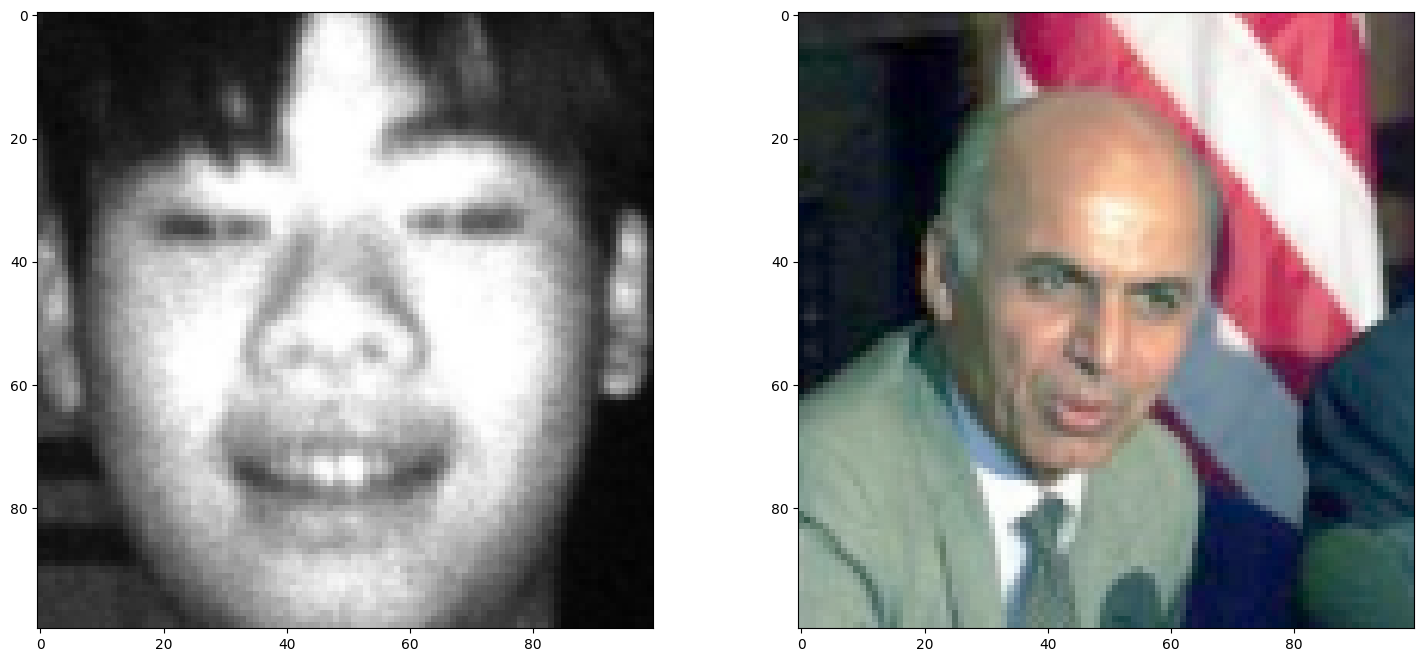

NOT the same person


In [106]:
#sample_in_batch = 0 # Choose the first image in the batch
sample_in_batch = 9

# Set plot size
plt.figure(figsize=(18,8))

# Set subplot. The subplot function allows you to render using a grid like format
# The first argument is the number of rows, the second is the number of columns, 
# and the third is the index of the current plot
plt.subplot(1,2,1)
plt.imshow(test_input[sample_in_batch])
plt.subplot(1,2,2)
plt.imshow(test_validation[sample_in_batch])
plt.show()

# Show the label
if (test_labels[sample_in_batch] == 1):
    print("Same person")
else:
    print("NOT the same person")

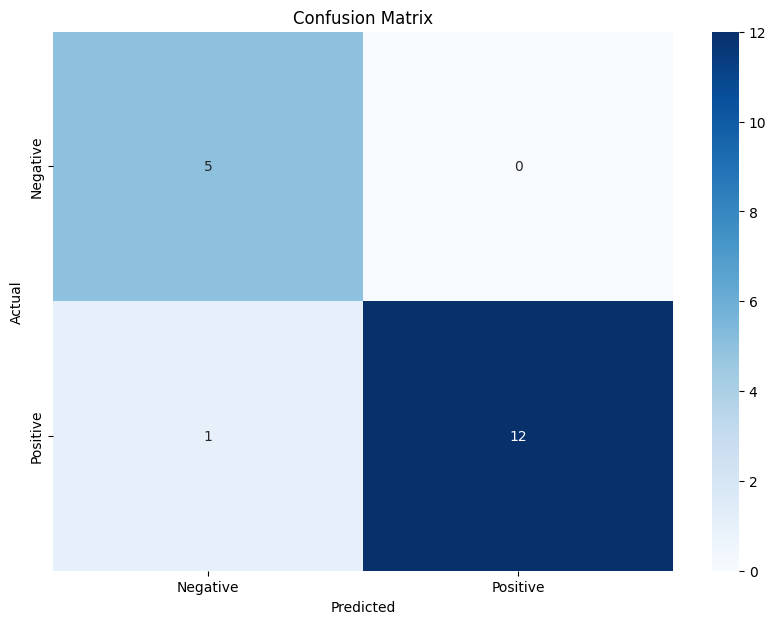

Precision: 1.0
Recall: 0.9230769230769231


In [107]:
# That is the result for an exmample batch, not we apply to the whole test data: draw the cofusion matrix and calculate the precision and recall and als
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns


# Create empty lists to store the predictions and labels
predictions = []
labels = []

# Loop through the test data
for batch in test_data:
    # Get the input images, validation images and labels from a batch
    input_images, validation_images, test_labels = batch
    # Make predictions
    preds = fully_siamese_model([input_images, validation_images])
    # Append the predictions and labels to the lists
    predictions.extend(preds)
    labels.extend(test_labels) 

# Convert the lists to numpy arrays
predictions = np.array(predictions)
labels = np.array(labels)

# Apply a threshold to the predictions
threshold = 0.5
predictions = (predictions > threshold).astype(int)


# Calculate the confusion matrix
cm = confusion_matrix(labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision and recall
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)

print(f'Precision: {precision}')
print(f'Recall: {recall}')



## 6.2 Save the model

**Uncomment to save the model when run the notebook for the first time**, after that, comment the code to avoid save the model again.

In [63]:
# First, we save our model weights
#fully_siamese_model.save('fully_siamese_model.h5')

Load the model from saved file

In [108]:
## Load the model from the saved file ##
import tensorflow as tf
# Reload the model
model = tf.keras.models.load_model('fully_siamese_model.h5', 
                                   custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy},
                                   compile=False)
# Without complie=false cause Warning: WARNING:absl:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


load_weights method can be used to load the weight also. The save_weights() method saves only the weights, the save() method saves optmizer state as well

The first parameter is the path to save the model, the second parameter is going to load our custom layers/objects. Because we got these inside our notebook alreadly, we do not need to do anything here, but when we deploy the model, we need to provide the custom objects to load the model correctly.

In [109]:
# Now to use the model, by using
model.predict([test_input, test_validation])

/home/chutrunganh/Projects/Biometric_IT4432E/venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_image', 'validation_image']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[9.9324143e-01],
       [2.6607532e-11],
       [8.8075407e-14],
       [1.5615520e-12],
       [1.1736380e-12],
       [8.8449425e-01],
       [3.1055826e-08],
       [2.6985144e-04],
       [5.9959209e-01],
       [3.4381110e-02],
       [7.9673195e-01],
       [8.1179633e-06],
       [1.0508536e-11],
       [9.9147159e-01],
       [7.2076881e-01],
       [9.9986935e-01]], dtype=float32)

In [110]:
model.summary()

Model: "Fully_Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Siamese__embedding… │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ Siamese__embeddi… │
│                     │                   │            │ Siamese__embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Part 7:  Real time test

## Objectives

- Overall process, Setup verification images

- Build verify function (loop through all images then compare what input we are getting in from our webcam)

- Perfrom realtime recognition



## 7.1 Overall, Set up verification images

This is the step which we collect the personal images of that person for verification process. It is same like when you fist choose sign in option as Window Hello, you need to scan your face for the first time. These images will be store to compare with the iinput image each time you log in the computer later.


So the full process is: 

Access webcam -> retrive input image of user when they want to login (this input image is processed directly without store to any file) -> use this image to verify against a number of positive samples (these positive samples are just images we already collected as a part of our scanning process). We store the positives samples or called validation images  inside the `application_data/verification_images` folder. Each user on the system will have their own subfolder inside the `verification_images` folder.




With a input image, loop to compare against all, for example 50 positive images in `validation_images/user_name` folder -> Our verifiaction function will output 50 predictions. So for example, a input image + one verifacation image (1 of 50 images in folder) will be compared and the output will be a number between 0 and 1, then we must choose a threshold to determine if the input image is a match or not (detection threshold). Then after that, we get 50 results of matching or not matching. Then we choose a Verification threshold to determind the number of matching out of 50 to be considered a valid authentication, for example, choose the threshold to be 0.8, meaning that if 80% of the 50 images match the input image, then we consider the input image to be a match.


![VerificationProcess](resources/images/VerificationProcess.drawio.png)

In [111]:
# Create base directory
base_dir = 'application_data'
os.makedirs(base_dir, exist_ok=True)

# Create validation images directory
validation_dir = os.path.join(base_dir, 'validation_images')
os.makedirs(validation_dir, exist_ok=True)

# Prompt user to enter their name  to save the verifaction images of that person, then create
# a folder with the name of the person in the validation_images folder
name = input("Enter your name to store your personal verification data to system: ")
print("Scanning process begins, please look at the camera, rotate your head to the left and right")
print("Press 'p' to capture the images and store to the validation_images folder")
print("Press 'q' to stop the scanning process")


# Define the base path
VALIDATION_PATH = os.path.join('application_data', 'validation_images')
# Create directory with name
new_dir_path = os.path.join(VALIDATION_PATH, name)
os.makedirs(new_dir_path, exist_ok=True)

# Initialize the webcam
import uuid # For generating unique image file names

# Function to save the captured image to the specified folder
def save_image(image, folder_path, img_name):
    img_path = os.path.join(folder_path, img_name)
    cv2.imwrite(img_path, image)

# Initialize the webcam
cap = cv2.VideoCapture(CAM_ID)
# Load the Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Loop through every frame in the webcam feed
while cap.isOpened():
    
    ret, frame = cap.read()
    if not ret:
        break



    # Display the frame
    cv2.imshow('Face Scanning Process, p for capture, q for quite', frame)

    # Check for key presses
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord('p'):
        # Detect face in the frame then crop to 250x250 around the face and save to 'data/positive'
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            cropped_face = frame[y:y+h, x:x+w]
            resized_face = cv2.resize(cropped_face, (250, 250))
           
            # At scanning preocess, preprocess the image before save to file
            preprocessed_face = preprocess_wrapper(resized_face).numpy() # Preprocess the image, then convert to numpy array
            # Debugging: Check the shape and type of the preprocessed image
            print(f"Preprocessed face shape: {preprocessed_face.shape}, dtype: {preprocessed_face.dtype}")

            # Ensure the preprocessed image is in the correct format for saving
            preprocessed_face = (preprocessed_face * 255).astype(np.uint8)

            path = os.path.join(VALIDATION_PATH, name)
            save_image(preprocessed_face,path , str(uuid.uuid1())+ ".jpg")
            print("Image saved in ", path)
        else:
            # Show a dialog if no faces are detectedq
            print("No faces detected, look at the camera and cpature the image again")

    elif key == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()


Scanning process begins, please look at the camera, rotate your head to the left and right
Press 'p' to capture the images and store to the validation_images folder
Press 'q' to stop the scanning process


## 7.2 Verification function

Now we build the validation function which take the input image directly from the webcam, then compare with the images in the validation_images/user_name folder. the parameters of this function are:

- `frame`: the input image from the webcam, frame object from OpenCV
- `name`: the name of the user that are trying to login
- `model`: the model we trained before to generate prediction
- `detection_threshold`: the threshold to determine if the input image is a match or not
- `verification_threshold`: the threshold to determine the number of matching out of total sample to be considered a valid authentication
- `LIMIT_IMAGES_TO_COMPARE`: the number of images in the validation_images/user_name folder to compare with the input image. As we testing, it takes  170ms-200ms to compare one image. So increase this number will increase the time to compare, but also increase the security, otherhand, decrease this number will decrease the time to compare, but also decrease the security.


In [112]:

def verify (frame, name ,model, detection_threshold, verfication_threshold, LIMIT_IMAGES_TO_COMPARE):
    # Detection Threshold: Metric above which the prediction is considered as positive
    # Verification Threshold: Proportion of positive detections/ total positive samples

    # Example, it te out comes prediction is 0.7, and the detection threshold is 0.5, then the prediction is positive
    # If 30 / 50 images pass the detection threshold, then it pass the verification threshold

    # Create result array
    results = []

    # Load the input image directly from the Webcam, preprocess it
    input_img = preprocess(frame).numpy()

    # Process when the name is not existed in the validation_images folder
    if not os.path.exists(os.path.join(VALIDATION_PATH, name)):
        print("The name does not exist in the system")
        return results, False

    # Loop through all the images in the validation_images folder (with crossponding name)
    path_of_validation_subfolder = os.path.join(VALIDATION_PATH,name)
    print("Compare with images in foler:", path_of_validation_subfolder)

    for image in os.listdir(path_of_validation_subfolder)[:LIMIT_IMAGES_TO_COMPARE]: #Limit to only comapre LIMIT_IMAGES_TO_COMPARE images instead of all images inside folder
        
        # Get each validation image
        # preprocess function from Part 3
        # The 'name' user input will be used to named the folder in the validation_images folder
        
        # validation_images  alreadly preprocessed at the scanning process, so we just need to load the image

        # Why need to preprocess at the scanning process, but not here? -> reduce response time in real time
        validation_img = cv2.imread(os.path.join(path_of_validation_subfolder, image), cv2.COLOR_BGR2GRAY)

        # Ensure both images have the same shape and number of channels
        if input_img.shape != validation_img.shape:
            print(f"Shape mismatch: input_img shape {input_img.shape}, validation_img shape {validation_img.shape}")
            continue


        

        # Pass two of these images to the model, with  and store preditcion to the array
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        

    verification = np.sum(np.array(results) > detection_threshold) / len(results)
    if verification > verfication_threshold:
        verification = True
    else:
        verification = False

    # Return the verification result for futher processing
    return results, verification

## 7.3 Realtime Verification

Conbine everythings together, take a single image from Webcam, then call the `verify` function

Compare with images in foler: application_data/validation_images/cta2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


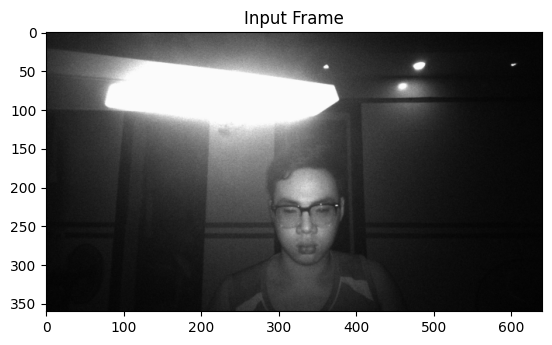

Verification Result: True
Model prediction of matching for each validation image: [1.0, 0.9999997615814209, 1.0, 0.9999997615814209]


In [114]:

# Ask who is trying to sign in
name = input("Who are you")

# Initialize the webcam
cap = cv2.VideoCapture(CAM_ID)
# Load the Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Loop through every frame in the webcam feed
while cap.isOpened():
    
    ret, frame = cap.read()
    if not ret:
        break



    # Display the frame
    cv2.imshow('Face Verification App, press v to capture', frame)

    # Check for key presses
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord('v'):
        # Detect face in the frame then crop to 250x250 around the face and save to 'data/positive'
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            cropped_face = frame[y:y+h, x:x+w]
            resized_face = cv2.resize(cropped_face, (250, 250))
        
            # Run verification
            # with the input image take directly from the webcam, the validation images are taken from the validation_images/name_that_user_input folder
            results, verification = verify(resized_face, name, model, 0.7, 0.7, 4)

            # Arguemnt: 0.7, 0.7, 2
            # 0.7: Detection threshold
            # 0.7: Verification threshold
            # 2: Limit the number of images to compare to when validation
            
            # print the result
            # Print the input frame
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title("Input Frame")
            plt.show()


            #Print out the result
            print("Verification Result:", verification)
            results = np.array(results).flatten().tolist()
            print("Model prediction of matching for each validation image:", results)



    

        else:
            # Show a dialog if no faces are detectedq
            print("No faces detected, look at the camera and cpature the image again")

        break


cap.release()
cv2.destroyAllWindows()
